In [1]:
import pandas as pd
import numpy as np

# import file
df = pd.read_csv('../../res/tp2/german_credit.csv', sep=',')

In [2]:
all_attrs = set(df)
all_attrs.remove('Creditability')

continuous_attrs = {'Duration of Credit (month)': ['<= 12', '<= 24', '<= 36', '<= 48', '<= 60', '> 60'],
                    'Credit Amount': ['<= 1000', '<= 2000', '<= 3000', '<= 4000', '<= 5000', '<= 6000', '<= 7000', '<= 8000',
                                      '<= 9000', '<= 10000', '<= 12000', '<= 14000', '> 14000'],
                    'Age (years)': ['< 30', '< 60', '>= 60']}
discrete_attrs = dict(map(lambda attr_name: (attr_name, list(df[attr_name].unique())),
                          filter(lambda attr_name: attr_name not in continuous_attrs, all_attrs)
                         ))
print(all_attrs)

{'Duration of Credit (month)', 'Occupation', 'Guarantors', 'Length of current employment', 'Sex & Marital Status', 'Type of apartment', 'Purpose', 'Duration in Current address', 'Account Balance', 'Credit Amount', 'No of dependents', 'Age (years)', 'Telephone', 'Foreign Worker', 'Most valuable available asset', 'Value Savings/Stocks', 'Instalment per cent', 'No of Credits at this Bank', 'Payment Status of Previous Credit', 'Concurrent Credits'}


In [3]:
from sklearn.model_selection import train_test_split

# Separar los datos en datos de entrenamiento y testeo
train, test = train_test_split(df, test_size=0.2)

test.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
87,1,4,36,3,3,4454,1,3,4,2,...,4,1,34,3,2,2,3,1,1,1
145,1,4,21,2,1,2476,5,5,4,3,...,4,1,46,3,2,1,4,1,2,1
282,1,4,12,2,1,4675,5,2,1,2,...,4,3,20,3,1,1,3,1,1,1
944,0,1,12,2,3,709,1,5,4,3,...,4,1,57,3,2,1,2,1,1,1
366,1,3,24,2,3,1258,3,3,3,2,...,3,3,57,3,2,1,2,1,1,1


In [4]:
import math

global entropy
entropy = None
positive_creditability = 'Creditability == 1'

def format_query_string(attr, value, index=-1):
    if attr in continuous_attrs:
        return f'not (`{attr}` {continuous_attrs[attr][index-1]}) and `{attr}` {value}' if index > 0 else f'`{attr}` {value}'
    
    return f'`{attr}` == {value}'

def get_entropy_term(p):
    return - p * math.log2(p) if not math.isclose(p, 0) else 0

def get_entropy(data, cond=positive_creditability): # H(S)
    positive_freq = len(data.query(cond)) / len(data) if len(data) != 0 else 0
    negative_freq = 1 - positive_freq if len(data) != 0 else 0
    entropy = get_entropy_term(positive_freq) + get_entropy_term(negative_freq)
    
    return entropy

def get_attr_entropy(data, cond): # H(Sv)
    positive_freq = len(data.query(cond)) / len(data) if len(data) != 0 else 0
    negative_freq = 1 - positive_freq if len(data) != 0 else 0
    return get_entropy_term(positive_freq) + get_entropy_term(negative_freq)

def get_rows_by_attr_cond(data, attr, cond, cond_index):
    rows = None
    
    if cond_index == 0:
        rows = data.query(f'`{attr}` {cond}')
    else:
        prev_cond = continuous_attrs[attr][cond_index-1]
        rows = data.query(f'not(`{attr}` {prev_cond}) and `{attr}` {cond}')
        
    return rows
    
def gain(data, attr, class_cond=positive_creditability):
    ret = get_entropy(data)
    
    if attr in continuous_attrs:
        for i, cond in enumerate(continuous_attrs[attr]):
            rows = get_rows_by_attr_cond(data, attr, cond, i)
            ret -= len(rows) / len(data) * get_attr_entropy(rows, class_cond)
            # print(f'{attr}: {ret}')
    else:
        for value in discrete_attrs[attr]: # TODO FIX: PREGUNTAR SI VALOR DE ATRIBUTO NO APARECE EN TRAIN, FALLA
            rows = data.query(f'`{attr}` == {value}')
            ret -= len(rows) / len(data) * get_attr_entropy(rows, class_cond)
            # print(f'{attr},{value}: {ret}')
    
    return ret

gains = {}
for attr in train.columns:
    if attr == 'Creditability':
        continue
    gains[attr] = gain(train, attr)

print(gains)

#df['Credit Amount'].hist(grid=True, bins=30, rwidth=0.9, color='#607c8e')
#print(get_entropy(train, train.Creditability == 1))

{'Account Balance': 0.08365598142652689, 'Duration of Credit (month)': 0.024935501830766784, 'Payment Status of Previous Credit': 0.049551807841100186, 'Purpose': 0.02734311852774282, 'Credit Amount': 0.03254230613015037, 'Value Savings/Stocks': 0.02814555430757144, 'Length of current employment': 0.008667844083606574, 'Instalment per cent': 0.0023978436893046934, 'Sex & Marital Status': 0.006020337178956968, 'Guarantors': 0.002568540534457958, 'Duration in Current address': 0.000685918819736786, 'Most valuable available asset': 0.014212855439270755, 'Age (years)': 0.007836262944407639, 'Concurrent Credits': 0.008531522990420544, 'Type of apartment': 0.010090095738872928, 'No of Credits at this Bank': 0.0024360404906771686, 'Occupation': 0.00014906703706665803, 'No of dependents': 3.564684190265899e-05, 'Telephone': 0.0025506292644583706, 'Foreign Worker': 0.00906541304545317}


In [5]:
from tree import Tree, NodeType

def get_max_gain(gains):
    max_attr = None
    max_gain = -1
    for attr, gain in gains.items():
        if gain > max_gain:
            max_gain = gain
            max_attr = attr
    return max_attr, max_gain

used_attrs = set({})

def add_level(data, current_level_attr, node=None, max_depth=None, stdout=False):
    global used_attrs
    
    if max_depth is not None:
        max_depth -= 1
    
    tree = None
    current_level_attr_node = None
    if node is None:
        tree = Tree()
        tree.root = current_level_attr_node = Tree.Node(NodeType.attr, current_level_attr)
    else:
        current_level_attr_node = node.add_child(NodeType.attr, current_level_attr)
    
    used_attrs.add(current_level_attr)
    
    values = continuous_attrs[current_level_attr] if current_level_attr in continuous_attrs else discrete_attrs[current_level_attr]
    for i, val in enumerate(values):
        
        if tree is not None and stdout:
            print(f'Processing value {val} for root attribute {tree.root.value}...')
        
        current_level_attr_value_node = current_level_attr_node.add_child(NodeType.val, val)
        rows = data.query(format_query_string(current_level_attr, val, i))
        
        # There are no rows matching all the branches' conditions, so we get the most frequent Creditability value
        # of the parent matching rows
        if (len(rows) == 0):
            current_level_attr_value_node.add_child(NodeType.leaf, data['Creditability'].mode()[0])
            continue
        
        classes = rows['Creditability'].unique()
        
        # Only positive or negative examples left (leaf)
        if len(classes) == 1:
            current_level_attr_value_node.add_child(NodeType.leaf, classes[0])
            continue
        else:
            selected_attrs = set(data) - set(['Creditability'])
            unprocessed_attrs = selected_attrs - used_attrs # Selected dataset columns - Used columns
            if len(unprocessed_attrs) == 0 or (max_depth is not None and max_depth <= 0):  # No more attributes to calculate gain for (leaf)
                current_level_attr_value_node.add_child(NodeType.leaf, rows['Creditability'].mode()[0])  # The most frequent value for Creditability
            else:
                current_gains = {}
                for attr in unprocessed_attrs:
                    current_gains[attr] = gain(rows, attr)
                next_level_attr, _ = get_max_gain(current_gains)
                # print(current_gains)
                if (next_level_attr is None):
                    raise Exception(f'Invalid state: gains returned attribute None - {current_gains}')
                else:
                    add_level(rows, next_level_attr, current_level_attr_value_node, max_depth)
    
    used_attrs.remove(current_level_attr)
    
    if tree:
        used_attrs.clear()
        return tree


#tr = Tree(root_attr)
#add_level(train, root_attr, tr.root)
#print('\n\n\n\n\n**********************************\n\n\n')
#print(tr)

In [14]:
def evaluate_condition(attr, asked_value, tree_cond): # attr = Age, asked_value = 28, tree_cond = '<= 30'
    if attr in continuous_attrs:
        index = continuous_attrs[attr].index(tree_cond)
        return eval(f'not ({asked_value} {continuous_attrs[attr][index-1]}) and {asked_value} {tree_cond}' if index > 0 else f'{asked_value} {tree_cond}')
        
    return asked_value == tree_cond


def classify(row, tree, stdout=False):
    """Given a row, navigate through the tree according to the constraints set by the row.
    """
    
    current_node = tree.root
    current_node_type = NodeType.attr
    
    while(current_node.children):
        current_node_val = current_node.value
        current_node_type = current_node.node_type
        if stdout:
            print(f'Node value: {current_node_val} - Type: {current_node_type}')
        
        if current_node_type == NodeType.attr:
            row_val = row[current_node_val]
            found_value = False
            for child in current_node.children:
                # print(f'Attr {current_node_val} Child Value: {child.value}')
                if evaluate_condition(current_node_val, row_val, child.value):
                    current_node = child
                    found_value = True
                    break
            if not found_value:
                raise Exception('Could not find attribute value')
        elif current_node_type == NodeType.val:
            current_node = current_node.children[0]
        else:
            raise Exception('Invalid State')
    
    if stdout:
        print(f'\nNode value: {current_node.value} - Type: {current_node.node_type}\n')
    return current_node.value


def build_tree(data, max_depth=None, stdout=False):
    root_gains = {}
    for attr in list(data):
        if attr == 'Creditability':
            continue
        root_gains[attr] = gain(data, attr)
    
    root_attr, _ = get_max_gain(root_gains)
    if (root_attr is None):
        raise Exception(f'Invalid state: gains returned attribute None - {root_gains}')
    
    tree = add_level(data, root_attr, max_depth=max_depth, stdout=stdout)
    if stdout:
        print(tree)
    return tree

# print(test.iloc[0])
# classify(test.iloc[0], tree)

In [15]:
import statistics as stats
from random import sample

def build_forest(data, sample_fraction=0.4, iterations=3, max_depth=None, stdout=False):
    forest = []
    selected_columns = list(data)
    
    # Every iteration builds a different tree
    while iterations > 0:
        print(f'Remaining trees: {iterations}')
            
        subset = data.sample(frac=sample_fraction, replace=True, axis=0)
        t = build_tree(subset, max_depth=max_depth, stdout=stdout)
        forest.append(t)
        iterations -= 1
        
        #print(f'\n\n\n\n\n\n\n\n************STARTING TREE************\n\n\n\n\n\n\n\n{t}')
        
    print('Done\n')
    return forest


def classify_random_forest(row, data=train, forest=None, max_depth=None, stdout=False):
    """Classify row with each tree and return the mode value for the class
    """
    
    if forest is None:
        forest = build_forest(data, max_depth=max_depth, stdout=stdout)
    classifications = []
    for tree in forest:
        classifications.append(classify(row, tree, stdout))
    if stdout:
        print(classifications)
    return stats.mode(classifications), forest

In [11]:
#row = test.iloc[0]
#print(row)
#print(classify_random_forest(row, stdout=True))

<AxesSubplot:>

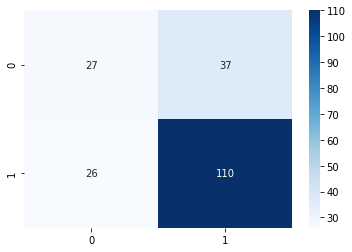

In [41]:
import seaborn as sns

id3_confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in id3_confusion_matrix.keys():
    columns.append(key)
    id3_confusion_matrix[key] = { 0: 0, 1: 0 } # {0: {0: 700, 1: 1048}, 1: {...}}

tree = build_tree(train)
for i in range(len(test)):
    row = test.iloc[i]
    creditability = row['Creditability']
    
    result = classify(row, tree=tree)
    id3_confusion_matrix[creditability][result] += 1

id3_confusion_df = { key : list(id3_confusion_matrix[key].values()) for key in id3_confusion_matrix.keys() }
id3_confusion_df = pd.DataFrame.from_dict(id3_confusion_df, orient='index', columns=columns)

sns.heatmap(id3_confusion_df, annot=True, cmap='Blues', fmt='g')

Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done



<AxesSubplot:>

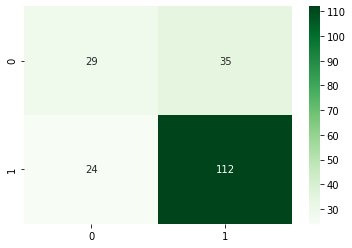

In [42]:
# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 } # {0: {0: 700, 1: 1048}, 1: {...}}

forest = build_forest(train, sample_fraction=0.6, iterations=9)
for i in range(len(test)):
    row = test.iloc[i]
    creditability = row['Creditability']
    
    result, _ = classify_random_forest(row, forest=forest)
    confusion_matrix[creditability][result] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Greens', fmt='g')

In [18]:
print(test['Creditability'].value_counts())

1    140
0     60
Name: Creditability, dtype: int64


In [38]:
def get_precision_plot_id3(train_data, test_data, depth_range, trees=None, stdout=False):
    plot_points = []
    should_build_trees = trees is None
    if should_build_trees:
        trees = []
    
    j = 0
    for i in depth_range:
        if stdout:
            print(f'Generating results using {i} as depth limit...')
        
        if should_build_trees:
            tree = build_tree(train_data, max_depth=i, stdout=False)
            trees.append(tree)
        else:
            tree = trees[j]
            j += 1
        
        correct_classifications = 0
        for index, row in test_data.iterrows():
            classification = classify(row, tree=tree)
            if classification == row['Creditability']:
                correct_classifications += 1
        
        plot_points.append(correct_classifications / len(test_data))
        if stdout:
            print(correct_classifications / len(test_data))
    
    if stdout:
        print(plot_points)
    
    return plot_points, trees

In [39]:
column_count = len(all_attrs)
attr_range = range(3, 8, 1)
id3_test_precisions, id3_trees = get_precision_plot_id3(train, test, attr_range, stdout=True)
id3_train_precisions, _ = get_precision_plot_id3(train, train, attr_range, trees=id3_trees, stdout=True)

Generating results using 3 as depth limit...
0.67
Generating results using 4 as depth limit...
0.69
Generating results using 5 as depth limit...
0.68
Generating results using 6 as depth limit...
0.685
Generating results using 7 as depth limit...
0.685
[0.67, 0.69, 0.68, 0.685, 0.685]
Generating results using 3 as depth limit...
0.8275
Generating results using 4 as depth limit...
0.9225
Generating results using 5 as depth limit...
0.97875
Generating results using 6 as depth limit...
0.99625
Generating results using 7 as depth limit...
0.99875
[0.8275, 0.9225, 0.97875, 0.99625, 0.99875]


Text(0, 0.5, 'Precisión')

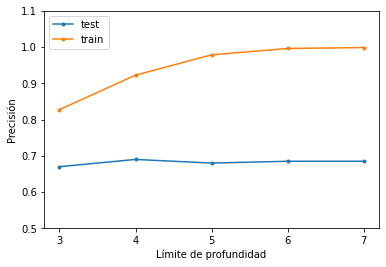

In [40]:
# Using ID3
id3_plot = pd.DataFrame({'test': id3_test_precisions, 'train': id3_train_precisions}, index=[i for i in attr_range])
id3_lines = id3_plot.plot(style='.-')
id3_lines.locator_params(integer=True)
id3_lines.set_ylim(0.5, 1.1)
id3_lines.set_xlabel('Límite de profundidad')
id3_lines.set_ylabel('Precisión')

In [24]:
def get_precision_plot_forest(train_data, test_data, depth_range, forests=None, sample_fraction=0.4, iterations=3, stdout=False):    
    plot_points = []
    should_build_forest = forests is None
    if should_build_forest:
        forests = []
    
    j = 0
    for i in depth_range:
        if stdout:
            print(f'Generating results using {i} as depth limit...')
        
        if should_build_forest:
            forest = build_forest(train_data, max_depth=i, sample_fraction=sample_fraction, iterations=iterations, stdout=False)
            forests.append(forest)
        else:
            forest = forests[j]
            j += 1
        
        correct_classifications = 0
        for index, row in test_data.iterrows():
            classification, _ = classify_random_forest(row, forest=forest)
            
            if classification == row['Creditability']:
                correct_classifications += 1
        
        plot_points.append(correct_classifications / len(test_data))
        print(correct_classifications / len(test_data))
    
    if stdout:
        print(plot_points)
    
    return plot_points, forests

In [25]:
column_count = len(all_attrs)
attr_range = range(3, 8, 1)
test_precisions, forests = get_precision_plot_forest(train, test, attr_range, sample_fraction=0.85, stdout=True)
print(len(forests))
train_precisions, _ = get_precision_plot_forest(train, train, attr_range, forests=forests, sample_fraction=0.85, stdout=True)

Generating results using 3 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

0.715
Generating results using 4 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

0.69
Generating results using 5 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

0.655
Generating results using 6 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

0.68
Generating results using 7 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

0.67
[0.715, 0.69, 0.655, 0.68, 0.67]
5
Generating results using 3 as depth limit...
0.8275
Generating results using 4 as depth limit...
0.89125
Generating results using 5 as depth limit...
0.90125
Generating results using 6 as depth limit...
0.91125
Generating results using 7 as depth limit...
0.9
[0.8275, 0.89125, 0.90125, 0.91125, 0.9]


Text(0, 0.5, 'Precisión')

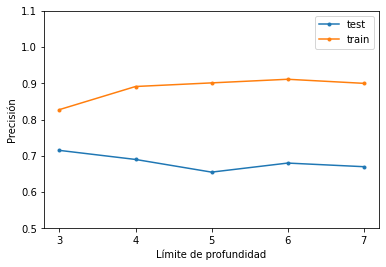

In [26]:
# Using Random Forest with 3 iterations
forest_plot = pd.DataFrame({'test': test_precisions, 'train': train_precisions}, index=[i for i in attr_range])
# forest_lines = forest_plot.plot.line()
# df = pd.DataFrame({'test': [0.65, 0.705, 0.655, 0.715, 0.67, 0.625, 0.62, 0.665, 0.67, 0.645, 0.625, 0.665, 0.66, 0.715, 0.685, 0.655, 0.675, 0.675], 'train': [0.7225, 0.76, 0.74625, 0.75375, 0.79, 0.81125, 0.79375, 0.8425, 0.82125, 0.84125, 0.83375, 0.815, 0.84125, 0.82625, 0.82875, 0.84, 0.8425, 0.81625]}, index=[i for i in attr_range])
forest_lines = forest_plot.plot(style='.-')
forest_lines.locator_params(integer=True)
forest_lines.set_ylim(0.5, 1.1)
forest_lines.set_xlabel('Límite de profundidad')
forest_lines.set_ylabel('Precisión')

In [27]:
column_count = len(all_attrs)
attr_range = range(3, 8, 1)
test_precisions_2, forests_2 = get_precision_plot_forest(train, test, attr_range, sample_fraction=0.85, iterations=9, stdout=True)
train_precisions_2, _ = get_precision_plot_forest(train, train, attr_range, forests=forests_2, sample_fraction=0.85, iterations=9, stdout=True)

Generating results using 3 as depth limit...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

0.71
Generating results using 4 as depth limit...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

0.73
Generating results using 5 as depth limit...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

0.715
Generating results using 6 as depth limit...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

0.675
Generating results using 7 as depth limit...
Remaining trees: 9
Remaining trees: 8
Remaini

Text(0, 0.5, 'Precisión')

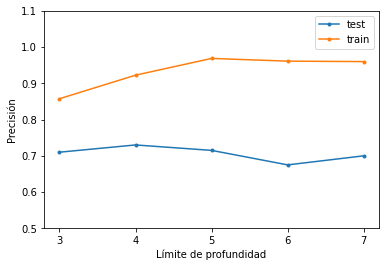

In [28]:
# Using Random Forest with 9 iterations
forest_plot_2 = pd.DataFrame({'test': test_precisions_2, 'train': train_precisions_2}, index=[i for i in attr_range])
forest_lines_2 = forest_plot_2.plot(style='.-')
forest_lines_2.locator_params(integer=True)
forest_lines_2.set_ylim(0.5, 1.1)
forest_lines_2.set_xlabel('Límite de profundidad')
forest_lines_2.set_ylabel('Precisión')